<a href="https://colab.research.google.com/github/mharalampopoulos2/FINALCISC5800/blob/main/Machine_Learning_Final_SMOTE_APPLIED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing from files - files will be provided in submission to replicate
import google.colab.files as files

uploaded = files.upload()


Saving Ad_Click_prediciton_test.csv to Ad_Click_prediciton_test.csv
Saving Ad_click_prediction_train (1).csv to Ad_click_prediction_train (1).csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import roc_auc_score, log_loss, roc_curve, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

#file handling
uploaded_files = list(uploaded.keys())
print("Uploaded files:", uploaded_files)

#manual config
TRAIN_PATH = uploaded_files[1]
TEST_PATH = uploaded_files[0]

#config
RANDOM_STATE = 42
TEST_SIZE = 0.2

Uploaded files: ['Ad_Click_prediciton_test.csv', 'Ad_click_prediction_train (1).csv']


In [ ]:
#read in and display sets - sanity check
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print("Training set:")
display(train_df.head())

Train shape: (463291, 15)
Test shape: (128858, 14)
Training set:


,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [ ]:
#check class balance values
print("Class balance:")
display(train_df["is_click"].value_counts(normalize=True))

#top 10 missingness to see if anything needs to be removed
print("Missingness (top 10):")
display(train_df.isna().mean().sort_values(ascending=False).head(10))

#drop features with high numbers of missing values
train_df.drop(["product_category_2", "city_development_index"], inplace=True, axis=1)
test_df.drop(["product_category_2", "city_development_index"], inplace=True, axis=1)

display(train_df.isna().mean().sort_values(ascending=False).head(10))

num_cols = train_df.drop(columns=["is_click"]).select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in train_df.drop(columns=["is_click"]).columns if c not in num_cols]

#sanity check
print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))


Class balance:


,proportion
is_click,
0,0.932373
1,0.067627


Missingness (top 10):


,0
product_category_2,0.789685
city_development_index,0.270087
gender,0.039377
user_group_id,0.039377
age_level,0.039377
user_depth,0.039377
session_id,0.000000
product_category_1,0.000000
webpage_id,0.000000
campaign_id,0.000000


,0
gender,0.039377
age_level,0.039377
user_depth,0.039377
user_group_id,0.039377
session_id,0.000000
campaign_id,0.000000
product,0.000000
user_id,0.000000
DateTime,0.000000
webpage_id,0.000000


Numeric features: 9
Categorical features: 3


In [ ]:
#drop any missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

#separate features from target to predict later on
y = train_df["is_click"]
X = train_df.drop(columns=["is_click"])

In [ ]:
#just in case we neeed to handle any string values in our predictions
#converting prediction set into binary feature
def coerceBinary(y):
    if y.dtype != object:
        return y.astype(int)
    return y.astype(str).str.lower().map({
        "1":1, "0":0, "yes":1, "no":0, "true":1, "false":0
    })

y = coerceBinary(y)

#pipeline creation
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [ ]:
#sanity check
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Train Head:", X_train.head())

Train shape: (356038, 12)
Validation shape: (89010, 12)
Train Head:         session_id          DateTime  user_id product  campaign_id  \
189608      544258  2017-07-04 13:23   571301       I        82320   
238275      508731  2017-07-05 05:57   551046       H       405490   
420353      199073  2017-07-07 10:11   129492       I       118601   
169870      446655  2017-07-04 08:01    63548       H       360936   
57869        28810  2017-07-02 18:12   295030       B       360936   

        webpage_id  product_category_1  user_group_id gender  age_level  \
189608        1734                   1            2.0   Male        2.0   
238275       60305                   3            2.0   Male        2.0   
420353       28529                   4            2.0   Male        2.0   
169870       13787                   3            4.0   Male        4.0   
57869        13787                   2            1.0   Male        1.0   

        user_depth  var_1  
189608         3.0      1  
2382

In [ ]:
#model creation for all 3 models
class_weights = y.value_counts(normalize=True).to_dict()
print("Class weights:", class_weights)

models = {
    "Logistic (L2)": LogisticRegression(
        max_iter=500, class_weight='balanced'
    ),

    "Logistic (L1 / Lasso)": LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight='balanced',
    max_iter=200

    ),

    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        max_iter=30,
        early_stopping=True,
        random_state=RANDOM_STATE,
        batch_size=int((0.005*len(X_train))//1),
        alpha=0.01,
        learning_rate_init=0.001,
        learning_rate="adaptive",
        activation="relu",
        verbose=1
    )
}

#create pipelines for easy and streamlined training process
pipelines = {
    name: Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])
    for name, model in models.items()
}

Class weights: {0: 0.9324634646150528, 1: 0.06753653538494724}


In [ ]:
#SMOTE application due to imbalanced classes
#should print pre and post-smote "no click" vs "click" value counts
X_train_proc = preprocess.fit_transform(X_train)
X_val_proc = preprocess.transform(X_val)

print("Before SMOTE:", np.bincount(y_train))

smote = SMOTE(random_state=RANDOM_STATE)
X_train_sm, y_train_sm = smote.fit_resample(
    X_train_proc, y_train
)

print("After SMOTE:", np.bincount(y_train_sm))


Before SMOTE: [331992  24046]
After SMOTE: [331992 331992]


In [ ]:
#L2
%%time #just for logging time due to problems early on

log_l2_model = pipelines["Logistic (L2)"].named_steps['model']

log_l2_model.fit(X_train_sm, y_train_sm)

probs_l2 = log_l2_model.predict_proba(X_val_proc)[:, 1]

auc_l2 = roc_auc_score(y_val, probs_l2)
ll_l2 = log_loss(y_val, probs_l2)

print("Logistic (L2)")
print("AUC:", auc_l2)
print("LogLoss:", ll_l2)

Logistic (L2)
AUC: 0.53091185499508
LogLoss: 0.6647553713215875
CPU times: user 39.8 s, sys: 9.01 ms, total: 39.8 s
Wall time: 24.1 s


In [ ]:
#L1
%%time

pipe_log_l1 = pipelines["Logistic (L1 / Lasso)"].named_steps['model']
pipe_log_l1.fit(X_train_sm, y_train_sm)

probs_l1 = pipe_log_l1.predict_proba(X_val_proc)[:, 1]

auc_l1 = roc_auc_score(y_val, probs_l1)
ll_l1 = log_loss(y_val, probs_l1)

print("Logistic (L1 / Lasso)")
print("AUC:", auc_l1)
print("LogLoss:", ll_l1)


Logistic (L1 / Lasso)
AUC: 0.5313980197619561
LogLoss: 0.6673509280525926
CPU times: user 8min 13s, sys: 512 ms, total: 8min 13s
Wall time: 8min 24s


In [ ]:
#mlp
%%time

pipe_nn = pipelines["Neural Network"].named_steps['model']
pipe_nn.fit(X_train_sm, y_train_sm)

probs_nn = pipe_nn.predict_proba(X_val_proc)[:, 1]

auc_nn = roc_auc_score(y_val, probs_nn)
ll_nn = log_loss(y_val, probs_nn)

print("Neural Network")
print("AUC:", auc_nn)
print("LogLoss:", ll_nn)

Iteration 1, loss = 0.50898136
Validation score: 0.891821
Iteration 2, loss = 0.18478353
Validation score: 0.939879
Iteration 3, loss = 0.10706142
Validation score: 0.949562
Iteration 4, loss = 0.07857562
Validation score: 0.955557
Iteration 5, loss = 0.06470915
Validation score: 0.956581
Iteration 6, loss = 0.05586382
Validation score: 0.959984
Iteration 7, loss = 0.05019884
Validation score: 0.961626
Iteration 8, loss = 0.04632489
Validation score: 0.963900
Iteration 9, loss = 0.04381390
Validation score: 0.961972
Iteration 10, loss = 0.04193285
Validation score: 0.960195
Iteration 11, loss = 0.04037996
Validation score: 0.962876
Iteration 12, loss = 0.03879662
Validation score: 0.961490
Iteration 13, loss = 0.03752323
Validation score: 0.967876
Iteration 14, loss = 0.03669442
Validation score: 0.962153
Iteration 15, loss = 0.03617429
Validation score: 0.966701
Iteration 16, loss = 0.03544172
Validation score: 0.966370
Iteration 17, loss = 0.03449463
Validation score: 0.966460
Iterat

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network
AUC: 0.5281974231874311
LogLoss: 1.112887403030634
CPU times: user 14min 41s, sys: 5.44 s, total: 14min 46s
Wall time: 8min 31s


,Model,AUC,LogLoss
1,Logistic (L1 / Lasso),0.531398,0.667351
0,Logistic (L2),0.530912,0.664755
2,Neural Network,0.528197,1.112887


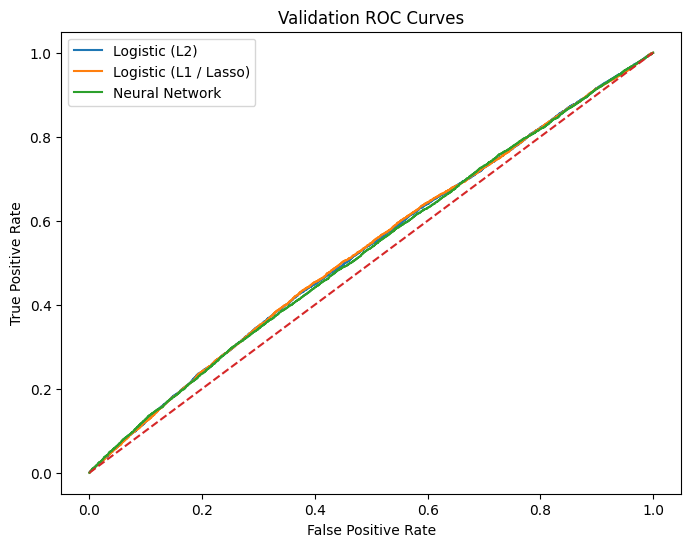

In [ ]:
#final results and roc curve graph (SMOTE applied)
results_df = pd.DataFrame([
    {"Model": "Logistic (L2)", "AUC": auc_l2, "LogLoss": ll_l2},
    {"Model": "Logistic (L1 / Lasso)", "AUC": auc_l1, "LogLoss": ll_l1},
    {"Model": "Neural Network", "AUC": auc_nn, "LogLoss": ll_nn}
]).sort_values("AUC", ascending=False)

display(results_df)

plt.figure(figsize=(8,6))

fpr, tpr, _ = roc_curve(y_val, probs_l2)
plt.plot(fpr, tpr, label="Logistic (L2)")

fpr, tpr, _ = roc_curve(y_val, probs_l1)
plt.plot(fpr, tpr, label="Logistic (L1 / Lasso)")

fpr, tpr, _ = roc_curve(y_val, probs_nn)
plt.plot(fpr, tpr, label="Neural Network")

plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curves")
plt.legend()
plt.show()

Probabilities for Logistic (L2):
[0.34154272 0.55243832 0.12895411 ... 0.38997826 0.32365347 0.56526389]
Probabilities for Logistic (L1 / Lasso):
[0.34750078 0.54152046 0.1298377  ... 0.38051916 0.33525836 0.5594111 ]
Probabilities for Neural Network:
[6.78325788e-08 5.87439597e-07 3.83709891e-11 ... 1.17840907e-09
 1.15241445e-07 8.66277629e-10]


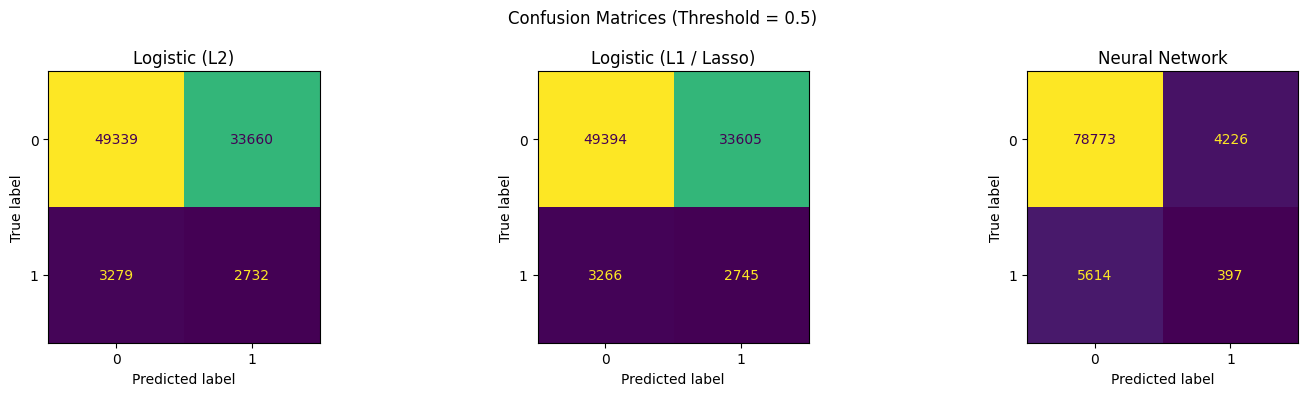

In [ ]:
#confusion matrices for SMOTE applied rates
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

THRESHOLD = 0.5

log_l2 = pipelines["Logistic (L2)"]
log_l1 = pipelines["Logistic (L1 / Lasso)"]
mlp = pipelines["Neural Network"]

models_for_cm = {
    "Logistic (L2)": log_l2.named_steps['model'], #actual mode estimators
    "Logistic (L1 / Lasso)": log_l1.named_steps['model'],
    "Neural Network": mlp.named_steps['model']
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, model) in zip(axes, models_for_cm.items()):
    probs = model.predict_proba(X_val_proc)[:, 1]
    print(f"Probabilities for {name}:")
    print(probs)
    preds = (probs >= THRESHOLD).astype(int)

    cm = confusion_matrix(y_val, preds)
    disp = ConfusionMatrixDisplay(cm)

    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)

plt.suptitle(f"Confusion Matrices (Threshold = {THRESHOLD})")
plt.tight_layout()
plt.show()

In [ ]:
# display metrics for each of the models (accuracy, precision, recall, f1)
for name, model in models.items():
    preds = model.predict(X_val_proc)
    print(f"{name}:")
    accuracy = accuracy_score(y_val, preds)
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print()

Logistic (L2):
Accuracy: 0.5850016852039097
Precision: 0.0750714442734667
Recall: 0.4545000831808351
F1 Score: 0.12885880715987078

Logistic (L1 / Lasso):
Accuracy: 0.5857656443096282
Precision: 0.07551581843191196
Recall: 0.45666278489436035
F1 Score: 0.12960033993531786

Neural Network:
Accuracy: 0.8894506235254466
Precision: 0.08587497296128055
Recall: 0.0660455830976543
F1 Score: 0.07466616513071281



In [ ]:
#test dataset predictions - done separately from other work due to previous mistake in splitting data
#test dataset not used for other analyses due to lack of target variable 'is_click'

X_test_proc = preprocess.transform(test_df)

test_predictions = pd.DataFrame({
    "session_id": test_df["session_id"],
    "Logistic_L2_prob": log_l2_model.predict_proba(X_test_proc)[:, 1],
    "Logistic_L1_prob": pipe_log_l1.predict_proba(X_test_proc)[:, 1],
    "Neural_Net_prob": pipe_nn.predict_proba(X_test_proc)[:, 1]
})

display(test_predictions.head())

,session_id,Logistic_L2_prob,Logistic_L1_prob,Neural_Net_prob
0,411705,0.515857,0.525342,1.718668e-07
3,547761,0.314176,0.329337,1.205335e-08
4,574275,0.524817,0.535612,2.242457e-14
5,394913,0.466469,0.479230,6.317581e-08
6,562747,0.533094,0.542397,4.787776e-12
